#EECS 442 PS6: Image Synthesis

__Please provide the following information__
(e.g. Andrew Owens, ahowens):

[Your first name] [Your last name], [Your UMich uniqname]

__Important__: after you download the .ipynb file, please name it as __"PS\<this_ps_number\>_\<your_uniqname\>.ipynb"__ before you submit it to canvas. Example: adam_01101100.ipynb.



__Note__: There are cells in this notebook that are specific to 504 students, if you are a 442 student please delete/comment them out while submitting the notebook/the pdf file.


# Starting

Run the following code to import the modules you'll need. After you finish the assignment, remember to run all cells and convert the notebook to a .pdf file for Gradescope submission.

In [4]:
!pip install torchsummary
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import itertools
from matplotlib import image
import glob as glob
from PIL import Image

import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
  print("Using the GPU!")
else:
  print("WARNING: Could not find GPU! Using CPU only. If you want to enable GPU, please to go Edit > Notebook Settings > Hardware Accelerator and select GPU.")


PyTorch Version:  2.0.0
Torchvision Version:  0.15.0


# Problem 6.3 style transfer (EECS 504)


## Step 0: Downloading the dataset and backbone network.
For this problem, we will use five images as our artistic style, and the Coco validation set as our content image.

A pretrained SqueezeNet will be applied to extract features.

In [5]:
if os.path.isdir('styles') and os.path.isdir('contents'):
  print('Style images exist')
else:
  print('Downloading images')
  # Download style images
  !wget https://eecs.umich.edu/courses/eecs442-ahowens/fa22/data/style_images.zip
  !unzip style_images.zip && rm style_images.zip

  # Download content images
  !wget http://images.cocodataset.org/zips/val2017.zip
  !unzip -q val2017.zip && rm val2017.zip
  !mkdir contents
  !mv val2017/* ./contents/

# Download the model
cnn = torchvision.models.squeezenet1_1(pretrained=True).features
cnn = cnn.to(device)

# Freeze the parameters as there's no need to train the net. Ignore the warnings.
for param in cnn.parameters():
    param.requires_grad = False

Style images exist


/Users/ziyangning/opt/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/ziyangning/opt/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## STEP 1: Create the image loader and some utility funtions
We provide the dataloader for images and a function to get the list of feature maps from a forward pass in the network.

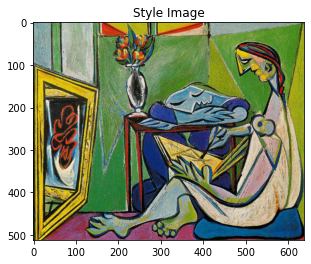

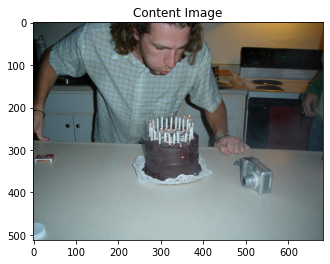

In [7]:
# Dataloader
imsize = 512

SQUEEZENET_MEAN = torch.tensor([0.485, 0.456, 0.406], dtype=torch.float)
SQUEEZENET_STD = torch.tensor([0.229, 0.224, 0.225], dtype=torch.float)


def image_loader(image_name, imsize):
    image = Image.open(image_name)
    transform = transforms.Compose([
                transforms.Resize(imsize),
                transforms.ToTensor(),
                transforms.Normalize(mean=SQUEEZENET_MEAN.tolist(), std=SQUEEZENET_STD.tolist()),
                transforms.Lambda(lambda x: x[None]),
                ])
    image = transform(image)
    return image.to(device, torch.float)

# visualizing the content and style images

style_img = image_loader("styles/muse.jpg", imsize)
content_img = image_loader("contents/000000211825.jpg", imsize)

def deprocess(img):
    transform = transforms.Compose(
        [
            transforms.Lambda(lambda x: x[0]),
            transforms.Normalize(mean=[0, 0, 0], std=(1.0 / SQUEEZENET_STD).tolist()),
            transforms.Normalize(mean=(-SQUEEZENET_MEAN).tolist(), std=[1, 1, 1]),
            transforms.Lambda(lambda x: x),
            transforms.ToPILImage(),
        ]
    )
    return transform(img)

plt.ion()

def imshow(im_tensor, title=None):
    image = im_tensor.cpu().clone()    
    image = deprocess(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

In [8]:
def get_feature_maps(x, cnn):
    """
    Get the list of feature maps in a forward pass.
    
    Inputs:
    - x: A batch of images with shape (B, C, H, W)
    - cnn: A PyTorch model that we will use to extract features.
    
    Returns:
    - features: A list of features for the input images x extracted using the cnn model.
      features[i] is a Tensor of shape (B, C_i, H_i, W_i).
    """
    feats = []
    in_feat = x
    for layer in cnn._modules.values():
        out_feat = layer(in_feat)
        feats.append(out_feat)
        in_feat = out_feat
    return feats

## Step 2: Implementing content loss
First, we will implement the {\em content loss}. This loss encourages the generated image to match the scene structure of the content image. We will implement this loss as the squared $\ell_2$ distance between two convolutional feature maps. Given a feature map of input image $F^x$ and the feature map of content image $F^{c}$, both of shape $(C, H, W)$, the content loss is calculated as follows:

\begin{equation}
\mathcal{L}_c = \sum_{c,i,j}(F^{c}_{c, i, j} - F^{x}_{c, i, j}) ^ 2. 
\end{equation}

In [ ]:
def content_loss(f_x, f_con):
    """
    Compute the gram matrix without loop.
    
    Inputs:
    - f_x: features of the input image with size (1, C, H, W).
    - f_cont: features of the content image with size (1, C, H, W).
    Returns:
    - lc: the content loss
    """

    lc = None

    ###########################################################################
    # TODO: Implement the content loss.                                       #
    # You can check your content loss with some code blocks below             #
    ###########################################################################
       
    #I don't think I am doing this corretly 
    lc = torch.einsum('cij,cij->c',f_con,f_x)
    
    #MSELOSS function
    pass
    
    ###########################################################################
    #                              END OF YOUR CODE                           #
    ###########################################################################

    return lc


## Step 3: Implementing style loss
Next, we will implement the {\em style loss}. This loss encourages the texture of the resulting image to match the input style image. We compute a weighted, squared $\ell_2$ distance between Gram matrices for several layers of the network.

The first step is to calculate the Gram matrix. Given a feature map $F$ of size $(C, H, W)$, the Gram matrix $G \in \mathbb{R}^{C \times C}$ computes the sum of products between channels. The entries $k, l$ of the matrix are computed as:
\begin{equation}
G_{k,l} = \sum_{i,j} F_{k,i,j} F_{l,i,j}.
\end{equation}

The second step is to compare the generated image's Gram matrix with that of the input style image. Define the Gram matrix of input image feature map and style image feature map of at the $l^{th}$ layer as $G^{x,l}$ and $G^{s, l}$, and the weight of the layer as $w^l$. Style loss at the $l^{th}$ layer is
\begin{equation}
L_s^l = w^l \sum_{i,j} (G^{x,l}_{i,j} - G^{s, l}_{i,j})^2,
\end{equation}
where $w^l$ is the weight of layer $l$. The total style loss is a sum over all style layers:
\begin{equation}
    \mathcal{L}_s = \sum_l L_s^l.
\end{equation}

In [24]:
def gram_matrix(feat, normalize = True):
    """
    Compute the gram matrix.
    
    Inputs:
    - feat: a feature tensor of shape (1, C, H, W).
    - normalize: if normalize is true, divide the gram matrix by C*H*W:
    Returns
    - gram: the gram matrix
    """

    gram = None

    ###########################################################################
    # TODO: Implement the gram matrix. You should not use a loop or           #
    # comprehension                                                           #
    ###########################################################################
    
    #gram = torch.einsum('kij,lij->kl',feat,feat) #the gram matrix implementation
    #Do I need to do to C,H,W here? or that's only for normalize
    #What happens to the 1 in the shape in the front?
    # or we can try flatten feat, then do matrix multiplication with transpose
    
    feat = feat.view(feat.size(1), -1)
    gram = torch.mm(feat, feat.t())
    
    if(normalize):
        #normalize if true
        gram = gram / (feat.size(0) * feat.size(1))
    
    pass

    ###########################################################################
    #                              END OF YOUR CODE                           #
    ###########################################################################

    return gram

In [25]:
t1.size(0)

1

In [27]:
# Test your gram matrix, you should be expecting a difference smaller than 0.001
t1 = torch.arange(8).reshape(1,2,2,2)
result = torch.tensor([[[ 1.7500,  4.7500],[ 4.7500, 15.7500]]])
print(((gram_matrix(t1) - result)**2).sum().item())

0.0


In [28]:
print(result)

tensor([[[ 1.7500,  4.7500],
         [ 4.7500, 15.7500]]])


In [30]:
gram_matrix(t1)

tensor([[ 1.7500,  4.7500],
        [ 4.7500, 15.7500]])

In [ ]:
def style_loss(feats, style_layers, style_targets, style_weights):
    """
    Computes the style loss at a set of layers.
    
    Inputs:
    - feats: list of the features at every layer of the current image, as produced by
      the extract_features function. The list will contain the features of all layers 
      instead of the layers for calcculating style loss
    - style_layers: List of layer indices into feats giving the layers to include in the
      style loss.
    - style_targets: List of the same length as style_layers, where style_targets[i] is
      a PyTorch Tensor giving the Gram matrix of the source style image computed at
      layer style_layers[i].
    - style_weights: List of the same length as style_layers, where style_weights[i]
      is a scalar giving the weight for the style loss at layer style_layers[i].
      
    Returns:
    - loss: A PyTorch Tensor holding a scalar giving the style loss.
    """

    loss = None

    ###########################################################################
    # TODO: Implement the style loss                                          #   
    # You can check your style loss with some code blocks below               #
    ###########################################################################

    pass

    ###########################################################################
    #                              END OF YOUR CODE                           #
    ###########################################################################

    return loss

## Step 4: Network Training
Test out your style transfer!

In [ ]:
def style_transfer(content_image, style_image, image_size, style_size, content_layer, content_weight,
                   style_layers, style_weights, init_random = False):
    """
    Run style transfer!
    
    Inputs:
    - content_image: filename of content image
    - style_image: filename of style image
    - image_size: size of smallest image dimension (used for content loss and generated image)
    - style_size: size of smallest style image dimension
    - content_layer: layer to use for content loss
    - content_weight: weighting on content loss
    - style_layers: list of layers to use for style loss
    - style_weights: list of weights to use for each layer in style_layers
    - init_random: initialize the starting image to uniform random noise
    """
    
    # Extract features for the content image
    content_img = image_loader(content_image, image_size)
    feats = get_feature_maps(content_img, cnn)
    content_target = feats[content_layer].clone()

    # Extract features for the style image
    style_img = image_loader(style_image, style_size)
    feats = get_feature_maps(style_img, cnn)
    style_targets = []

    for idx in style_layers:
        style_targets.append(gram_matrix(feats[idx].clone()))

    # Initialize output image to content image or nois
    if init_random:
        img = torch.Tensor(content_img.size()).uniform_(0, 1).to(device)
    else:
        img = content_img.clone().to(device)

    # We do want the gradient computed on our image!
    img.requires_grad_()
    
    # Set up optimization hyperparameters
    initial_lr = 1
    decayed_lr = 0.1
    decay_lr_at = 180

    # Note that we are optimizing the pixel values of the image by passing
    # in the img Torch tensor, whose requires_grad flag is set to True
    optimizer = torch.optim.Adam([img], lr=initial_lr)
    
    plt.figure()
    imshow(style_img, title='Style Image')

    plt.figure()
    imshow(content_img, title='Content Image')
    
    for t in range(200):
        if t < 190:
            img.data.clamp_(-1.5, 1.5)
        optimizer.zero_grad()

        feats = get_feature_maps(img, cnn)
        
        # Compute loss
        c_loss = content_loss(feats[content_layer], content_target) * content_weight
        s_loss = style_loss(feats, style_layers, style_targets, style_weights)
        loss = c_loss + s_loss
        
        loss.backward()

        # Perform gradient descents on our image values
        if t == decay_lr_at:
            optimizer = torch.optim.Adam([img], lr=decayed_lr)
        optimizer.step()

        if t % 100 == 0:
            print('Iteration {}'.format(t))
            plt.figure()
            imshow(img, title='Transferred Image')
            plt.show()
    print('Iteration {}'.format(t))
    plt.figure()
    imshow(img, title='Final transferred Image')


In [ ]:
# Check of content loss. Ignore the style image.
params_content_check = {
    'content_image':'contents/000000211825.jpg',
    'style_image':'styles/muse.jpg',
    'image_size':192,
    'style_size':512,
    'content_layer':2,
    'content_weight':3e-2,
    'style_layers':[1, 4, 6, 7],
    'style_weights':[0, 0, 0, 0],
    'init_random': True
}

style_transfer(**params_content_check)

In [ ]:
# Check of style loss. You should see the texture of the image. Ignore the content image.
params_style_check = {
    'content_image':'contents/000000211825.jpg',
    'style_image':'styles/texture.jpg',
    'image_size':192,
    'style_size':512,
    'content_layer':2,
    'content_weight':0,
    'style_layers':[0, 1],
    'style_weights':[200000, 200000],
    'init_random': True
}

style_transfer(**params_style_check)

In [ ]:
params1 = {
    'content_image':'contents/000000211825.jpg',
    'style_image':'styles/muse.jpg',
    'image_size':192,
    'style_size':512,
    'content_layer':2,
    'content_weight':3e-2,
    'style_layers':[1, 4, 6, 7],
    'style_weights':[200000, 800, 12, 1],
}

style_transfer(**params1)

In [ ]:
params2 = {
    'content_image':'contents/000000118515.jpg',
    'style_image':'styles/starry_night.jpg',
    'image_size':192,
    'style_size':192,
    'content_layer':3,
    'content_weight':3e-2,
    'style_layers':[1, 4, 6, 7],
    'style_weights':[200000, 800, 12, 1],
}

style_transfer(**params2)

In [ ]:
params3 = {
    'content_image':'contents/000000002157.jpg',
    'style_image':'styles/the_scream.jpg',
    'image_size':192,
    'style_size':224,
    'content_layer':2,
    'content_weight':3e-2,
    'style_layers':[1, 4, 6, 7],
    'style_weights':[200000, 800, 12, 1],
}

style_transfer(**params3)

# Feel free ot change the images and get your own style transferred image

### **TODO**: 
Finally, we will try varying the layer used to compute the content loss. Try
different layers l = 0, 1, 2, ..., 12 and report which one provides the best qualitative results.

***replace this line with your answer***

# Convert Notebook to PDF

[Alternative if the cell below doesn't work.](https://docs.google.com/document/d/1QTutnoApRow8cOxNrKK6ISEkA72QGfwLFXbIcpvarAI/edit?usp=sharing)

In [ ]:
import os
from google.colab import drive
from google.colab import files

drive_mount_point = '/content/drive/'
drive.mount(drive_mount_point)

In [ ]:
# generate pdf
# Please provide the full path of the notebook file below
# Important: make sure that your file name does not contain spaces!

# Ex: notebookpath = '/content/drive/My Drive/Colab Notebooks/EECS_442_PS4_FA_2022_Starter_Code.ipynb'
notebookpath = '*** copy paste your path here ***' 

file_name = notebookpath.split('/')[-1]
get_ipython().system("apt update && apt install texlive-xetex texlive-fonts-recommended texlive-generic-recommended")
get_ipython().system("jupyter nbconvert --to PDF {}".format(notebookpath.replace(' ', '\\ ')))
files.download(notebookpath.split('.')[0]+'.pdf')